In [1]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os as so
import numpy as ny
from os import path
import pandas as ps
import pathlib as pb
from typing import List
from modules import models
import matplotlib.pyplot as pt
import matplotlib as mb
from modules import processing as pg
from numpy.random import default_rng
from tensorflow.keras.optimizers import Adam
from torch.optim import lr_scheduler as sch_lr
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from modules.blocks import Swish
from numpy.random import default_rng
import modules.params as params
import mpl_toolkits as mts
import copy
import torch
import typing


# Configure the paths to the data files
ROOT_PATH = pb.Path('..')
DATASET_PATH = pb.Path(path.join(ROOT_PATH, 'data'))
DATASET_TEST_PATH = pb.Path(path.join(DATASET_PATH, 'test'))
DATASET_TRAIN_PATH = pb.Path(path.join(DATASET_PATH, 'train'))
SUBMISSIONS_PATH = pb.Path(path.join(ROOT_PATH, 'submissions'))
DATASET_TRAIN_LABELS_FILEPATH = pb.Path(path.join(DATASET_PATH, 'train_labels.csv'))

# Use GPU if available
so.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2023-01-05 17:17:22.909950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 17:17:23.040793: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-05 17:17:23.525132: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cudnn/lib64:
2023-01-05 17:17:23.525170: W tensorflow/compiler/x

In [3]:
import tensorflow as tw

# Show warning if running on CPU
available_devices = list(map(lambda d: d.device_type, tw.config.list_physical_devices()))
print('Available devices = ', tw.config.list_physical_devices())

if 'GPU' not in available_devices:
  print('Warning: running on CPU only')

Available devices =  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-05 17:17:25.085415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 17:17:25.094797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 17:17:25.094917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
# Load the data from disk
dataset = pg.load_dataset(DATASET_PATH)
train_data, train_labels = dataset['train']
test_data = dataset['test']

Number of training samples:  9000
Shape of a training sample:  (150, 3)
Number of testing samples:  5000
Shape of a testing sample:  (150, 3)


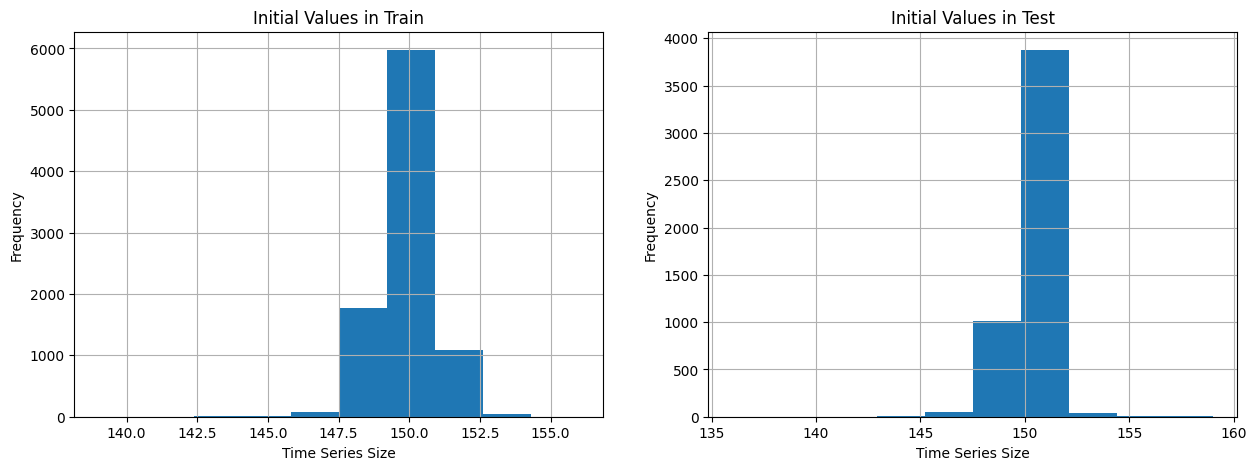

In [5]:
# Compute sizes in order to search for potential missing values in each time series
train_sizes = [sample.shape[0] for sample in train_data]
test_sizes = [sample.shape[0] for sample in test_data]

# Display missing value stats
pt.figure(figsize=(15, 5))
for i, (sizes, title) in enumerate([(train_sizes, 'train'), (test_sizes, 'test')]):
  pt.subplot(1, 2, i + 1)
  pt.title(f'Initial Values in {title.capitalize()}')
  pt.xlabel('Time Series Size')
  pt.ylabel('Frequency')
  pt.hist(sizes)
  pt.grid(True)

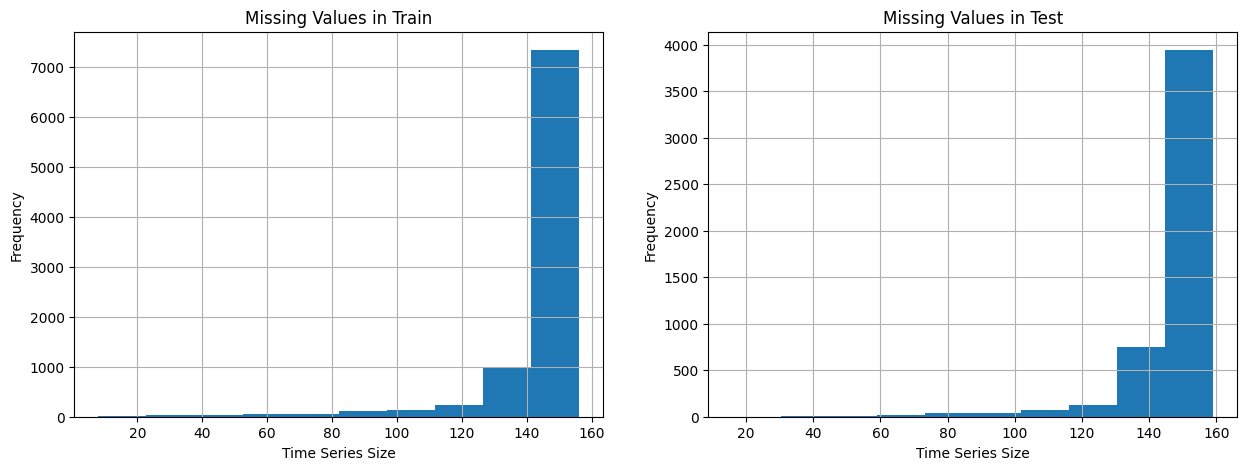

In [6]:
# Remove outliers by class & global from training data
no_outliers_train_data, \
no_outliers_train_labels = pg.remove_outliers(train_data,
                                              train_labels, by='global', factor=1.5)

# Remove only outlier globally from testing data as no labels are given for class strategy
no_outliers_test_data = pg.remove_outliers(test_data, by='global', factor=1.5)

# Compute sizes in order to search for potential missing values in each time series
train_sizes = [sample.shape[0] for sample in no_outliers_train_data]
test_sizes = [sample.shape[0] for sample in no_outliers_test_data]

# Display missing value stats
pt.figure(figsize=(15, 5))
for i, (sizes, title) in enumerate([(train_sizes, 'train'), (test_sizes, 'test')]):
  pt.subplot(1, 2, i + 1)
  pt.title(f'Missing Values in {title.capitalize()}')
  pt.xlabel('Time Series Size')
  pt.ylabel('Frequency')
  pt.hist(sizes)
  pt.grid(True)

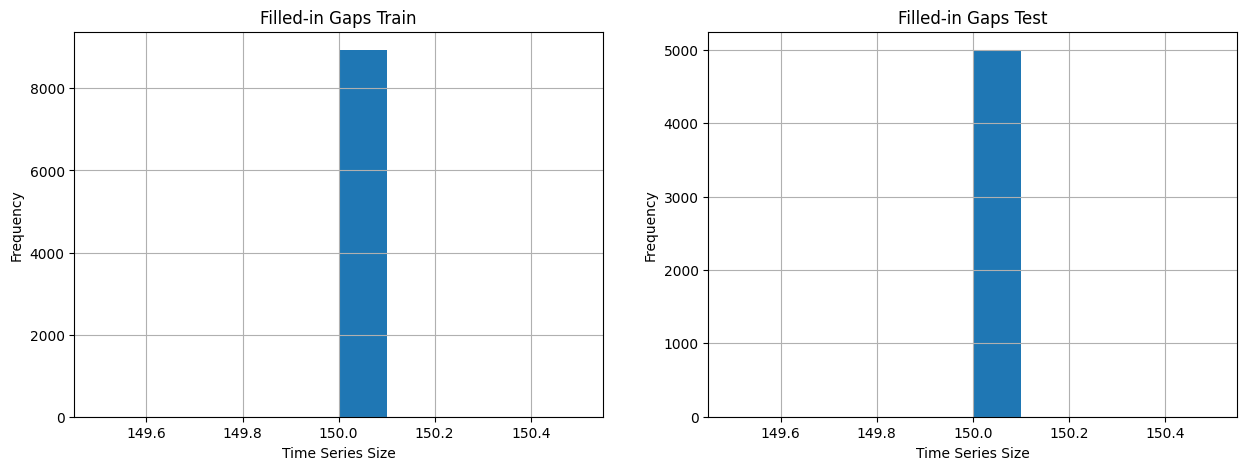

In [7]:
# Fill holes using interpolation
no_gaps_train_data, \
no_gaps_train_labels = pg.fill_gaps(no_outliers_train_data, no_outliers_train_labels, n_size=150, min_limit=50)
no_gaps_test_data = pg.fill_gaps(no_outliers_test_data, n_size=150, min_limit=None)

# Compute sizes in order to search for potential missing values in each time series
train_sizes = [sample.shape[0] for sample in no_gaps_train_data]
test_sizes = [sample.shape[0] for sample in no_gaps_test_data]

# Display missing value stats
pt.figure(figsize=(15, 5))
for i, (sizes, title) in enumerate([(train_sizes, 'train'), (test_sizes, 'test')]):
  pt.subplot(1, 2, i + 1)
  pt.title(f'Filled-in Gaps {title.capitalize()}')
  pt.xlabel('Time Series Size')
  pt.ylabel('Frequency')
  pt.hist(sizes)
  pt.grid(True)

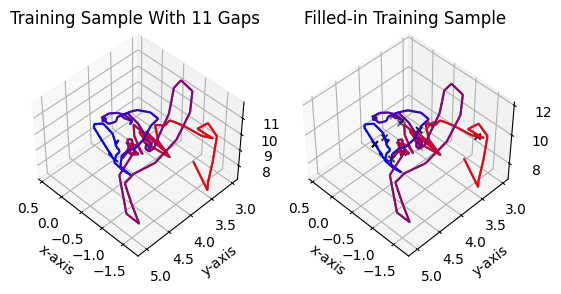

In [8]:
# Get smallest sequence from the data
min_i = 0
for i in range(len(train_data)):
  if train_data[i].shape[0] < train_data[min_i].shape[0]:
      min_i = i

# Fill the gaps without removing outliers
train_data_filled, \
train_labels_filled, \
train_data_gaps = pg.fill_gaps(train_data, train_labels, n_size=150, gaps=True)
f = pt.figure()

# Show sequence with gaps
sample = train_data[min_i]
x, y, z = ny.array(sample).T
ax0_3d = f.add_subplot(1, 2, 1, projection='3d')
pg.plot_seq(sample, ax0_3d, lines=True, points=False)
ax0_3d.set_title(f'Training Sample With {150-train_data[min_i].shape[0]} Gaps')

# Show filled-in sequence
sample = train_data_filled[min_i]
x, y, z = ny.array(sample).T
ax1_3d = f.add_subplot(1, 2, 2, projection='3d')
pg.plot_seq(sample, ax1_3d, True, False)
pg.plot_seq(train_data_filled[min_i, train_data_gaps[min_i]], ax1_3d, lines=False, points=True)
ax1_3d.set_title('Filled-in Training Sample')
pt.show()

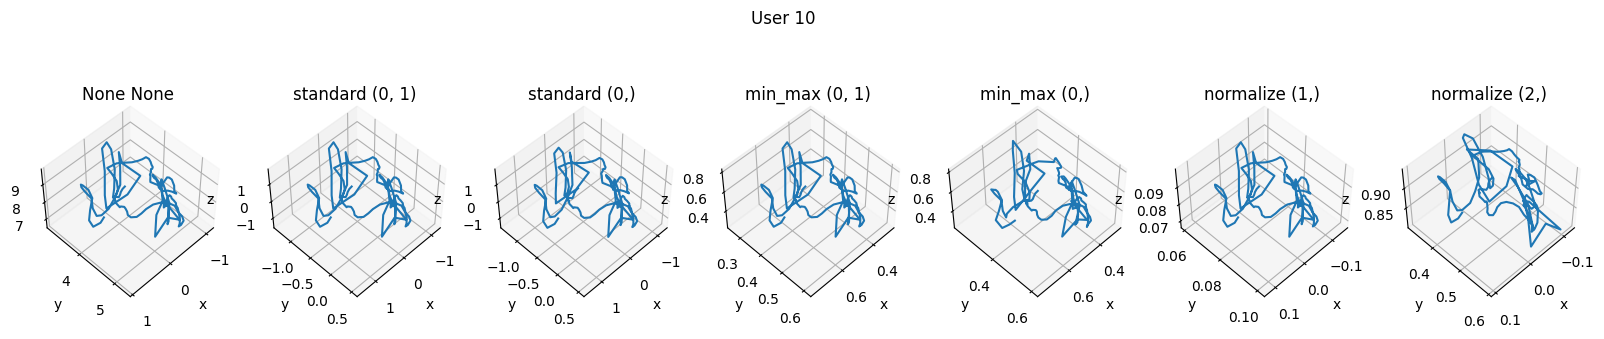

In [9]:
# Sample three recordings
gen = default_rng(24)
sample_i = 100
user_label = train_labels[sample_i]

# Try different normalization / feature scaling methods
strategies = (
  (None, None),         # => no operation is applied    => -
  ('standard', (0, 1)), # => for each coordiante        => 3
  ('standard', (0,)),   # => temporal * each coordiante => 150 x 3
  ('min_max', (0, 1)),  # => for each coordiante        => 3
  ('min_max', (0,)),    # => temporal * each coordiante => 150 x 3
  ('normalize', (1,)),  # => norm of each coordinate    => 9000 x 3
  ('normalize', (2,)),  # => norm of each time moment   => 9000 x 150
)

# Display a sample in both sensor space and normalized space
f = pt.figure(figsize=(20, 7))
f.suptitle(f'User {user_label}')
f.tight_layout()
for i, (strategy, axis) in enumerate(strategies):
  # Normalize to view different perspectives
  norm_train_data, \
  norm_test_data = pg.normalize(no_gaps_train_data, no_gaps_test_data, strategy, axis)

  # Retrieve normalized samples
  train_record = norm_train_data[sample_i]

  # Display scaled vectors
  plot_n = f.add_subplot(2, len(strategies), i + 1, projection='3d')
  plot_n.plot3D(train_record[:, 0], train_record[:, 1], train_record[:, 2])
  plot_n.set_title(f'{strategy} {axis}')
  plot_n.set_xlabel('x')
  plot_n.set_ylabel('y')
  plot_n.set_zlabel('z')
  plot_n.view_init(elev=50, azim=45)
pt.show()

In [18]:
# Model providers / factories
model_svm_factory = lambda: models.SVMModel({
  'C': 7,
  'gamma': 'auto',
  'kernel': 'rbf',
}, verbose=False)

model_knn_factory = lambda: models.KNNModel({
  'n_neighbors': 8,
  'p': 2,
})

model_boosted_trees_factory = lambda: models.BoostedTreesModel({
  'learning_rate': 0.4,
  'n_estimators': 20,
  'subsample': 0.5,
  'max_depth': 2,
}, verbose = 1)

model_tcnn_factory = lambda: models.TCNNModel({
  'optim': lambda: Adam(learning_rate=2e-4),
  'm_init': tw.keras.initializers.GlorotNormal(seed=24),
  'activ_fn': tw.keras.layers.Activation('swish'),
  'lr_update': (30, 10, 0.8),
  'n_filters': 256,
  's_filters': 3,
  'n_units': 2048,
  'dropout': 0.4,
  'n_epochs': 75,
  'n_batch': 48,
  'noise_std': 0.0,
}, ROOT_PATH)

model_attention_tcnn_factory = lambda: models.AttentionTCNNModel({
  'sch_lr': lambda o, v: sch_lr.StepLR(o, step_size=40, gamma=2e-1, verbose=v),
  'optim': lambda params: torch.optim.Adam(params, lr=2e-4, weight_decay=3e-4),
  'init_fn': lambda w: torch.nn.init.xavier_normal_(w),
  'activ_fn': Swish,
  'bottleneck': 4,
  'dropout': 0.3,
  's_filters': 3,
  'n_filters': 256,
  'n_epochs': 100,
  'n_units': 512,
  'n_batch': 32,
  'norm': True,
  'bias': True,
}, device=device, verbose=True)

def hybrid(cl_model_factory: typing.Callable[[], models.Model]):
  ae_model = models.AutoEncoderModel({
    'sch_lr': lambda o, v: sch_lr.ReduceLROnPlateau(o, 'min', verbose=v, patience=7, cooldown=2),
    'optim': lambda params: torch.optim.Adam(params, lr=1e-3),
    'init_fn': lambda w: torch.nn.init.xavier_normal_(w),
    'loss_fn': torch.nn.L1Loss(reduction='none'),
    'activ_fn': Swish,
    'embedding_features': 1024,
    'n_filters': 32,
    'dropout': 0.1,
    'n_epochs': 50,
    'n_batch': 32,
    'bias': True,
  }, device=torch.device('cuda'), verbose=True)
  return models.HybridAutoEncoderClassifier(ae_model, cl_model_factory())
model_hybrid_factory = lambda: hybrid(model_svm_factory)

# Setup current model to be used
model_factory = model_svm_factory

In [16]:
# Display periodic plots across each fold
pt.figure()

# Configure kfold loop
tparams: params.TrainParams = {
  'n_folds': 5,
}

# Train and validate using crossvalidation technique
trn_accy, val_accy = [], []
train_dummy = ny.empty((9000, 450))
for i, (fold_train, fold_valid) in enumerate(KFold(shuffle=True, n_splits=tparams['n_folds'], random_state=24).split(train_dummy)):
  # Indicate current iteration
  print(f"{tparams['n_folds']}-Fold: {i + 1}")

  # Create new model with random weights
  model = model_factory()

  # Select subsets using the given indices
  train_data_subset = [train_data[i] for i in fold_train]
  valid_data_subset = [train_data[i] for i in fold_valid]
  train_labels_subset = [train_labels[i] for i in fold_train]
  valid_labels_subset = [train_labels[i] for i in fold_valid]

  # Preprocess the data
  train_data_subset,   \
  train_labels_subset, \
  valid_data_subset,   \
  valid_labels_subset = pg.preprocess(train_data_subset,
                                      train_labels_subset,
                                      valid_data_subset,
                                      valid_labels_subset,
                                      outliers=None,
                                      pos_embedding=True)

  # Learn on training data and predict on valid set
  history = model.fit(train_data_subset, train_labels_subset, \
                      valid_data_subset, valid_labels_subset)

  # Save max valid & train accy for the current fold
  val_accy.append(history.accuracy[1])
  trn_accy.append(history.accuracy[0])

  # Display fold results
  history.show()

# Show results across all folds
pt.show()
pt.figure()
print(f'mean_val_accy = {ny.mean(val_accy)}')
print(f'mean_trn_accy = {ny.mean(trn_accy)}')

# Show val across folds
pt.subplot(1, 2, 1)
pt.grid(True)
pt.xlabel('nth Fold')
pt.ylabel('Accuracy')
pt.title('Validation Accuracy')
pt.plot(ny.arange(tparams['n_folds']), val_accy)

# Show train across folds
pt.subplot(1, 2, 2)
pt.grid(True)
pt.xlabel('nth Fold')
pt.ylabel('Accuracy')
pt.title('Training Accuracy')
pt.plot(ny.arange(tparams['n_folds']), trn_accy)
pt.show()

5-Fold: 1


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

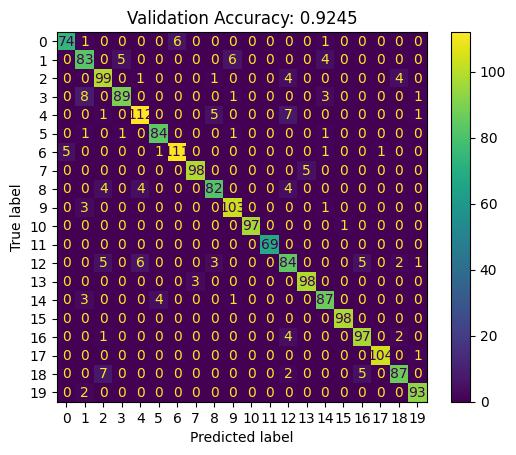

In [20]:
# Recreate model to train from scratch for subtask
model = model_factory()

# Split data indices
# indices = default_rng(76).choice(len(train_data), size=len(train_data), replace=False)
indices = ny.arange(len(train_data))
n_subset_valid = 2_000
n_subset_train_i = len(train_data) - n_subset_valid
n_subset_valid_i = n_subset_train_i

# Get indices and extract the elements
train_i = indices[:n_subset_train_i]
valid_i = indices[n_subset_valid_i:]
train_data_subset = [train_data[i] for i in train_i]
valid_data_subset = [train_data[i] for i in valid_i]
train_labels_subset = [train_labels[i] for i in train_i]
valid_labels_subset = [train_labels[i] for i in valid_i]

# Preprocess the data
train_data_subset,   \
train_labels_subset, \
valid_data_subset,   \
valid_labels_subset = pg.preprocess(train_data_subset, train_labels_subset, \
                                    valid_data_subset, valid_labels_subset,pos_embedding=True)

# Fit model on all training data except last 2_000 entries
model.fit(train_data_subset, train_labels_subset)

# Predict on last 2_000 entries
m_cnf = model.conf(valid_data_subset, valid_labels_subset)

# Transform back to labels instead of probs
f = pt.figure()
a = f.add_subplot()
a.set_title(f'Validation Accuracy: {m_cnf.trace() / m_cnf.sum()}')
ConfusionMatrixDisplay(m_cnf).plot(ax=a)
pt.show()

In [19]:
# Instantiate model for final prediction on test set
model = model_factory()

# Fit on the entire training to have more data for further predictions
rnd_indices = default_rng(76).choice(len(train_data), size=len(train_data), replace=False)

# Get indices and extract the elements
test_data_subset = test_data
train_data_subset = [train_data[i] for i in rnd_indices]
train_labels_subset = [train_labels[i] for i in rnd_indices]

# Preprocess the data
train_data_subset,   \
train_labels_subset, \
test_data_subset = pg.preprocess(train_data_subset, train_labels_subset, \
                                 test_data_subset)

# Fit model on all training examples and predict on the test subset
history = model.fit(train_data_subset, train_labels_subset)
print(history.accuracy[0])
history.show()

# Predict unknown labels
test_pred_labels = model.predict(test_data_subset)

KeyboardInterrupt: 

In [31]:
# Create resulting test object
test_ids = ps.Series([p.stem for p in sorted(DATASET_TEST_PATH.glob('*.csv'))], name='id')
test_classes = ps.Series(test_pred_labels, name='class')
test_results = ps.DataFrame({
  'id': test_ids,
  'class': test_classes,
})

# And store the results obtained by the model using that previously created test frame
test_results.to_csv(SUBMISSIONS_PATH / 'test_labels_44.csv', mode='w', header=True, index=False)